# Fine tune model using resnet 18

## Why ResNet 18

ResNet-18 is a convolutional neural network that is 18 layers deep. It is part of the ResNet (Residual Network) family, which introduced the concept of residual learning to address the vanishing gradient problem in deep networks. ResNet-18 is particularly known for its simplicity and ease of implementation, making it an excellent choice for fine-tuning tasks. Its relatively shallow architecture compared to other ResNet variants allows for faster training and inference, which is ideal for scenarios with limited computational resources. This makes ResNet-18 a popular model for transfer learning and fine-tuning on custom datasets.

# Preprocessing data

In [85]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from keras.utils import normalize
from PIL import Image
from sklearn.model_selection import train_test_split

In [86]:
no_dir = os.listdir('./data_no/data_no/NO/')
yes_dir = os.listdir('./data_yes/data_yes/YES/')

data_set,label = [],[]
for i,cur_img_dir in enumerate(no_dir):
    #check type of image
    if cur_img_dir.split('.')[1]=='jpg':
        img = cv2.imread('./data_no/data_no/NO/'+cur_img_dir)
        img = Image.fromarray(img,'RGB')
        img = img.resize((64,64))
        data_set.append(np.array(img))
        label.append(0)

for i,cur_img_dir in enumerate(yes_dir):
    #check type of image
    if cur_img_dir.split('.')[1]=='jpg':
        img = cv2.imread('./data_yes/data_yes/YES/'+cur_img_dir)
        img = Image.fromarray(img,'RGB')
        img = img.resize((64,64))
        data_set.append(np.array(img))
        label.append(1)


In [87]:
data_set = np.array(data_set)
label = np.array(label)
data_set.shape

(1092, 64, 64, 3)

## Split and normalize data


In [88]:
seed = 99
tf.random.set_seed(seed)
np.random.seed(seed)


In [89]:
x_train,x_test,y_train,y_test = train_test_split(
    data_set,label,
    test_size=0.2,
    random_state=9
    )
x_train,x_val,y_train,y_val = train_test_split(
        x_train,y_train,
    test_size=0.25,
    random_state=9
)
print(f'X train shape: {x_train.shape}\nY train shape: {y_train.shape}\nX test shape: {x_test.shape}\nY test shape: {y_test.shape}\nX validation shape: {x_val.shape}\nY validation shape: {x_val.shape}')

X train shape: (654, 64, 64, 3)
Y train shape: (654,)
X test shape: (219, 64, 64, 3)
Y test shape: (219,)
X validation shape: (219, 64, 64, 3)
Y validation shape: (219, 64, 64, 3)


### Adding scaler method of nb4


In [90]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib 
# using scaler of nb4
scaler = joblib.load('scaler.pkl') 
# Reshape data to fit with MinMaxScaler
x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])
x_val_reshaped = x_val.reshape(-1, x_val.shape[-1])

x_train_reshaped = scaler.fit_transform(x_train_reshaped)
x_test_reshaped = scaler.transform(x_test_reshaped)
x_val_reshaped = scaler.transform(x_val_reshaped)

# Reshape to original shape
x_train = x_train_reshaped.reshape(x_train.shape)
x_test = x_test_reshaped.reshape(x_test.shape)
x_val = x_val_reshaped.reshape(x_val.shape)

# Building model

## download lib


In [91]:
!pip install torch torchvision

In [92]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**update 05/09 - change output layer**

In [93]:
import torch.nn as nn
import torch

# Adding more layer and sigmoid layer for output

class CustomResNet18(nn.Module):
    def __init__(self, original_model):
        super(CustomResNet18, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Remove the last fully connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initila ResNet18 model
model = CustomResNet18(model)

In [94]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [95]:
#config cpu, gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [96]:
print(f'X train shape: {x_train.shape}\nY train shape: {y_train.shape}\nX test shape: {x_test.shape}\nY test shape: {y_test.shape}\nX validation shape: {x_val.shape}\nY validation shape: {x_val.shape}')


X train shape: (654, 64, 64, 3)
Y train shape: (654,)
X test shape: (219, 64, 64, 3)
Y test shape: (219,)
X validation shape: (219, 64, 64, 3)
Y validation shape: (219, 64, 64, 3)


In [97]:
from torchsummary import summary
summary(model, (3, 64, 64)) # model, input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### Prepare data

In [98]:
from torch.utils.data import DataLoader, TensorDataset
import torch

#convert data to tensor
# Thay đổi thứ tự các chiều của tensor từ (batch_size, height, width, channels)
# thành (batch_size, channels, height, width) (định dạng pytorch)
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)  
Y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Thêm chiều cho Y_train
X_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
Y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2)
Y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Define loss and optimizer

In [99]:
import torch.optim as optim

criterion = nn.BCELoss()  # Binary Cross Entropy Loss cho phân loại nhị phân
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)  # Sử dụng Adam với amsgrad=True

## Training model

In [39]:
import matplotlib.pyplot as plt

# Training model
num_epochs = 20
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Đánh giá mô hình trên tập validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}%")


Epoch 1/20, Loss: 0.3039472315992628, Val Loss: 0.6613535242421287, Val Accuracy: 84.47488584474885%
Epoch 2/20, Loss: 0.11048806272447109, Val Loss: 0.15949674589293344, Val Accuracy: 94.9771689497717%
Epoch 3/20, Loss: 0.06261105498387701, Val Loss: 0.05255347862839699, Val Accuracy: 98.63013698630137%
Epoch 4/20, Loss: 0.03256162025943576, Val Loss: 0.12243366268064294, Val Accuracy: 94.52054794520548%
Epoch 5/20, Loss: 0.04286859970584157, Val Loss: 0.29705294753823963, Val Accuracy: 90.8675799086758%
Epoch 6/20, Loss: 0.06058459179032417, Val Loss: 0.25584900698491503, Val Accuracy: 87.67123287671232%
Epoch 7/20, Loss: 0.06689576408825815, Val Loss: 0.13648260171924317, Val Accuracy: 96.80365296803653%
Epoch 8/20, Loss: 0.05285881988571158, Val Loss: 0.2483598930495126, Val Accuracy: 92.69406392694064%
Epoch 9/20, Loss: 0.08615501899094809, Val Loss: 0.09636895784309932, Val Accuracy: 95.89041095890411%
Epoch 10/20, Loss: 0.019688764318180757, Val Loss: 0.11967994113053594, Val Ac

***Plotting validation loss and accuracy (before change output layer - do not run again)***

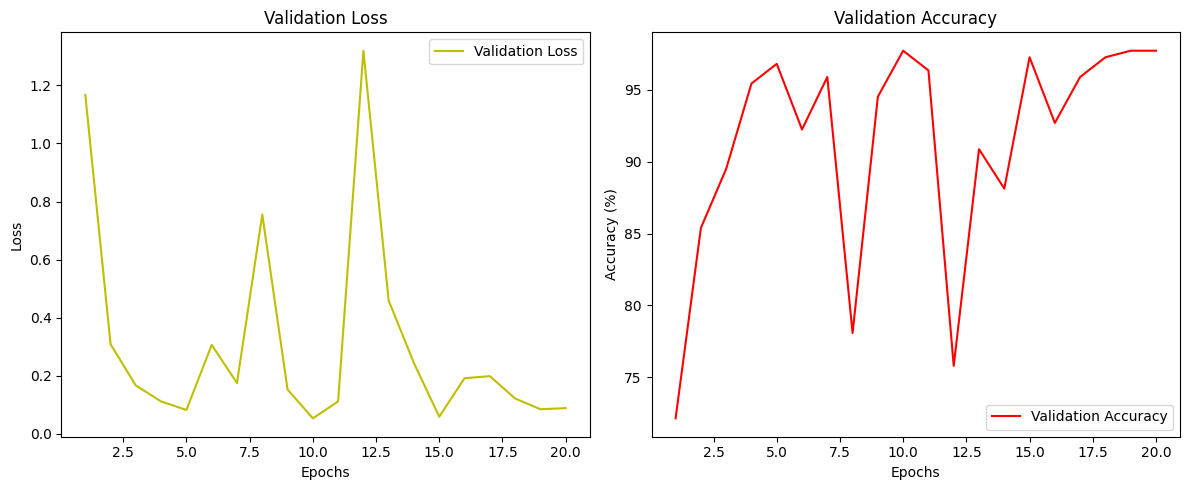

In [17]:
# epochs = range(1, num_epochs + 1)
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, val_losses, 'y', label='Validation Loss')  
# plt.title('Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()git

# plt.subplot(1, 2, 2)
# plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
# plt.title('Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.legend()

# plt.tight_layout()
# plt.show()

***Plotting validation loss and accuracy (after change output layer)***

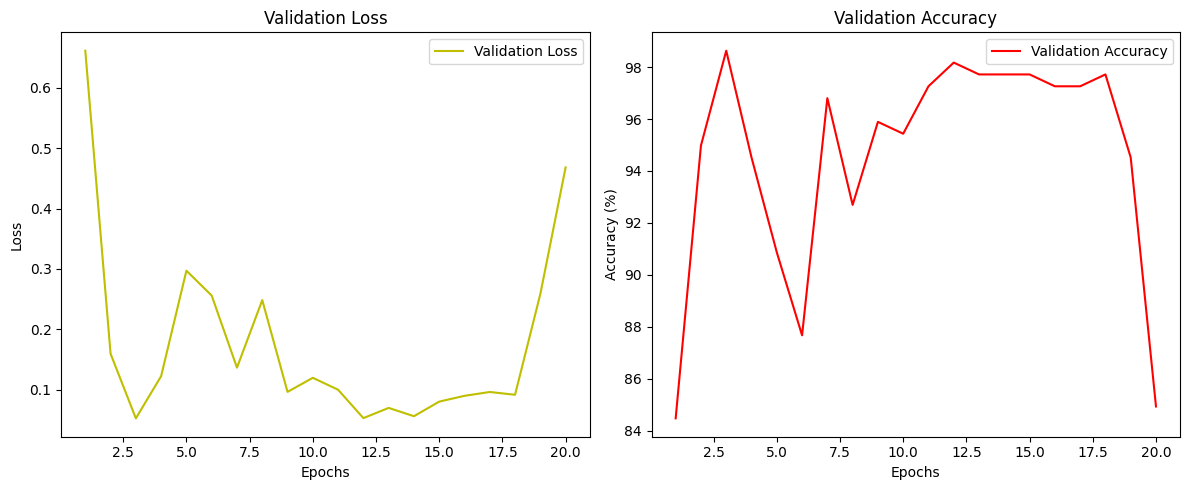

In [40]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'y', label='Validation Loss')  
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

**update 05/09 plot confusion matrix of model, calculate precision, recall and f1 score with test set**

Accuracy on test set: 91.32420091324201%
Confusion Matrix:
[[ 94  17]
 [  2 106]]
Precision: 0.8617886178861789
Recall: 0.9814814814814815
F1 Score: 0.9177489177489178


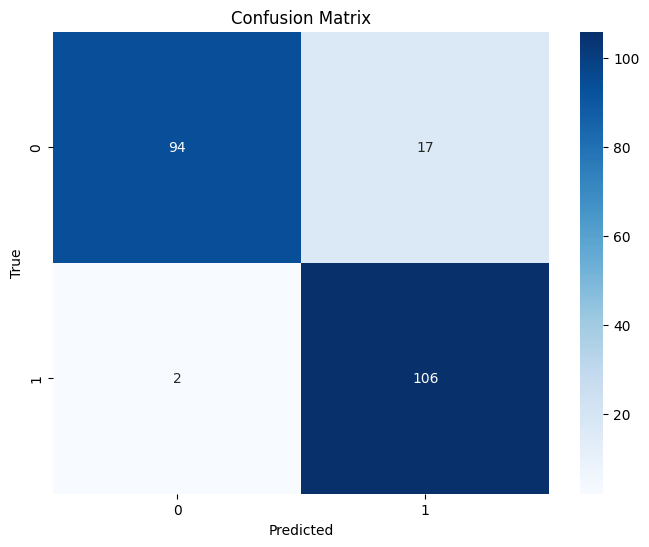

In [41]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Evaluate in test set
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy}%")

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
torch.save(model.state_dict(), 'BrainTumor_v4.pth')

* update 05/09: the model is not good so much because val loss increase in last epoch
* using early stopping and plot loss and accuracy in each iterator.

In [58]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [100]:
num_epochs = 20
early_stop_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Lists to store loss and accuracy at each epoch
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = (val_outputs > 0.5).float()
            total += val_labels.size(0)
            correct += (val_predicted == val_labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print accuracy and validation loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered")
            break

Epoch 1/20, Training Loss: 0.2894322638000761, Validation Loss: 3.4199652671813965, Validation Accuracy: 57.990867579908674%
Epoch 2/20, Training Loss: 0.09436104708306846, Validation Loss: 0.2943528039114816, Validation Accuracy: 91.78082191780823%
Epoch 3/20, Training Loss: 0.06101082298638565, Validation Loss: 0.31545419565268923, Validation Accuracy: 87.21461187214612%
Epoch 4/20, Training Loss: 0.060554966308353914, Validation Loss: 0.1077237818390131, Validation Accuracy: 94.9771689497717%
Epoch 5/20, Training Loss: 0.03143865169979455, Validation Loss: 0.17029947607911058, Validation Accuracy: 95.4337899543379%
Epoch 6/20, Training Loss: 0.05731498526819494, Validation Loss: 1.1856160078729903, Validation Accuracy: 76.71232876712328%
Epoch 7/20, Training Loss: 0.06735824001953006, Validation Loss: 0.10322891441839081, Validation Accuracy: 96.34703196347031%
Epoch 8/20, Training Loss: 0.030654582965542517, Validation Loss: 0.4306367923106466, Validation Accuracy: 89.0410958904109

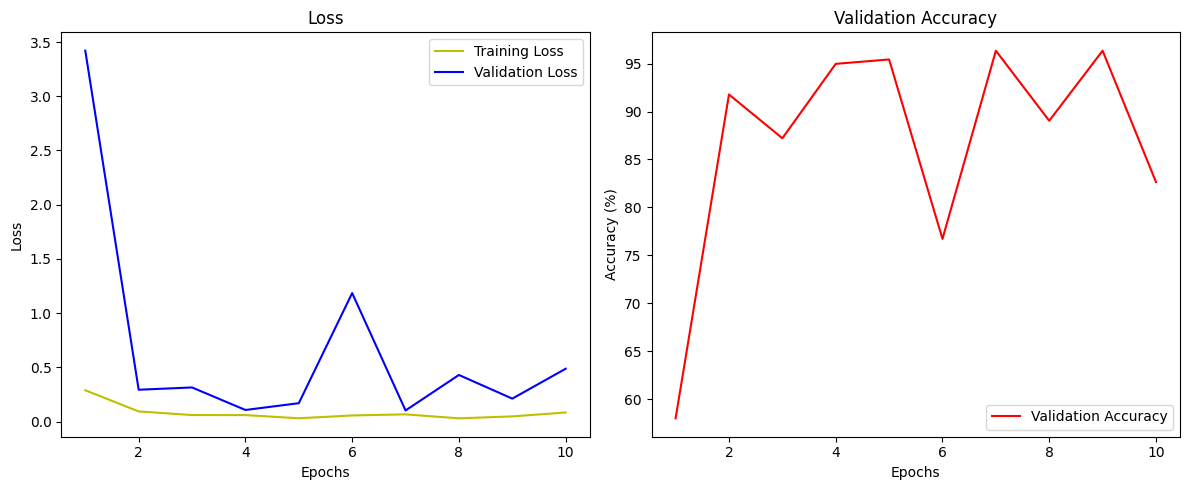

In [101]:
# Plotting loss and accuracy
epochs = range(1, len(val_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'y', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy on test set: 83.56164383561644%
Confusion Matrix:
[[ 75  36]
 [  0 108]]
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571


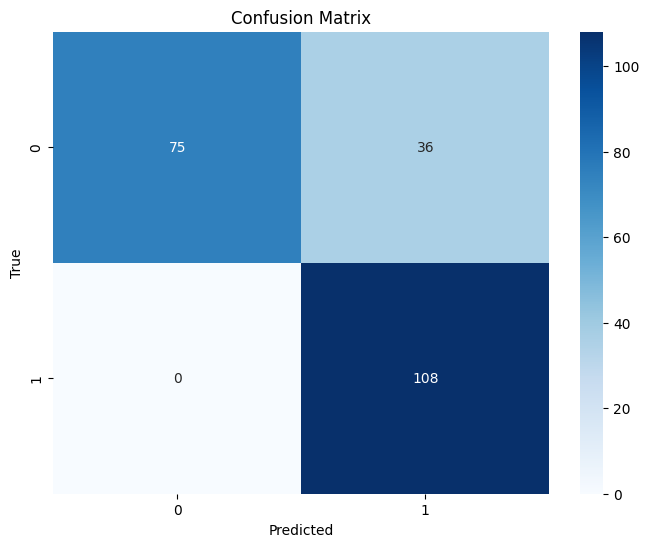

In [102]:
# Evaluate on test set
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy}%")

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()